In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import hist

from utils import *

In [2]:
# SPIRE channels
lambdas = [250, 350, 500]
psf     = {250:17.8, 350:24.0, 500:35.2} # in arcsec 
factor  = {250:469./36., 350:831./64., 500:1804./144.} # Jy/beam -> Jy/pixel 
reso    = {250:6., 350:8., 500:12.} # in arcsec 
positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5), 90:(20,20)}
boxsize = {250:51, 350:39, 500:27, 90:40}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# Results folder
results_folder = 'results_filt_H-ATLAS'

zbins = [(1.,2.15), (2.15,2.50),(2.50,5.0)]
# zbins = [(0.1, 1.), (1.,2.), (2.,3.), (3.,4.)]#, (4.,5.)]

rmax = 9

extras_names = [
    'Z',
    'JMAG',			 # J magnitude 2MASS
    'ERR_JMAG',		 # Error J magnitude 2MASS
    'HMAG',			 # H magnitude 2MASS
    'ERR_HMAG',		 # Error H magnitude 2MASS
    'KMAG',			 # K magnitude 2MASS
    'ERR_KMAG',		 # Error K magnitude 2MASS
    'W1MAG',		 # w1 magnitude WISE
    'ERR_W1MAG',     # Error w1 magnitude WISE
    'W2MAG',		 # w2 magnitude WISE
    'ERR_W2MAG',     # Error w1 magnitude WISE
    'W3MAG',		 # w3 magnitude WISE
    'ERR_W3MAG',     # Error w1 magnitude WISE
    'W4MAG',		 # w4 magnitude WISE
    'ERR_W4MAG',     # Error w1 magnitude WISE
    'CC_FLAGS',     # WISE contamination and confusion flag
    'UKIDSS_MATCHED',# UKIDSS matched
    'YFLUX',         # Y-band flux density [Jy]
    'YFLUX_ERR',     # Error in Y-band density flux [Jy]
    'JFLUX',         # J-band flux density [Jy]
    'JFLUX_ERR',     # Error in J-band density flux [Jy]
    'HFLUX',         # H-band flux density [Jy]
    'HFLUX_ERR',     # Error in H-band density flux [Jy]
    'KFLUX',         # K-band flux density [Jy]
    'KFLUX_ERR',     # Error in K-band density flux [Jy]
    'PSFFLUX_U',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_G',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_R',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_I',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'PSFFLUX_Z',       # Flux in the ugriz bands (not corrected for Gal extin) [nanomaggies] 
    'IVAR_PSFFLUX_U',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_G',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_R',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_I',  # Inverse variance of ugriz fluxes
    'IVAR_PSFFLUX_Z',  # Inverse variance of ugriz fluxes
    'EXTINCTION_U',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_G',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_R',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_I',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_Z',       # Galactic extintion in the 5 SDSS bands (from Schlegel+98)      
    'EXTINCTION_RECAL_U', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_G', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_R', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_I', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'EXTINCTION_RECAL_Z', # Galactic extintion in the 5 SDSS bands (from Schafly&Finkbeiner11)      
    'FLUX02_12KEV',     # Total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_12KEV', # Error in total flux (0.2 - 12 keV) XMM [erg/cm^2/s]
    'FLUX02_2KEV',      # Soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'ERR_FLUX02_2KEV',  # Error in soft flux (0.2 - 2 keV) XMM [erg/cm^2/s]
    'FLUX2_12KEV',      # Hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'ERR_FLUX2_12KEV',  # Error in hard flux (2 - 12 keV) XMM [erg/cm^2/s]
    'LUM05_2KEV',       # Soft X-ray luminostiy [erg/s]
    'LUM2_12KEV',       # Hard X-ray luminostiy [erg/s]
    'LUM02_2KEV'        # Total X-ray luminostiy [erg/s]
    ]


In [4]:
anal = CutoutAnalysis('results_filt_H-ATLAS', zbins=[(1.,2.15), (2.15,2.50),(2.50,5.0)], extras_names=extras_names, lambdas=lambdas)

Parameter('amplitude', value=6.40801510782)


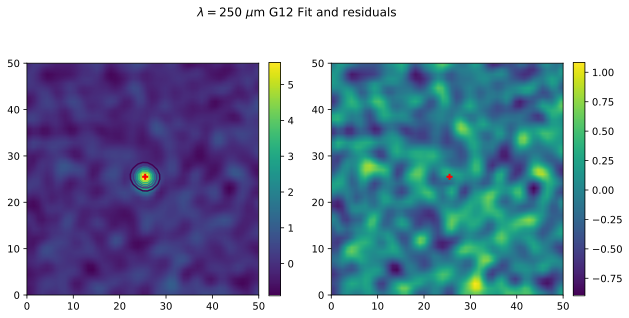

In [28]:
p = anal.GaussFit(250, 'G12', 0, remove_max=1, remove_mean=True, plot=True)


In [20]:
p = anal.FitGauss2D(350, 'G12', 2, remove_max=15, remove_mean=True, plot=False)

3.38791385025


utils.py:658: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cuts_id = np.random.choice(np.arange(simuls.shape[0]), size=simuls.shape[0]/nboot)
utils.py:709: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  cuts_id = np.random.choice(ncuts, size=ncuts/nboot)


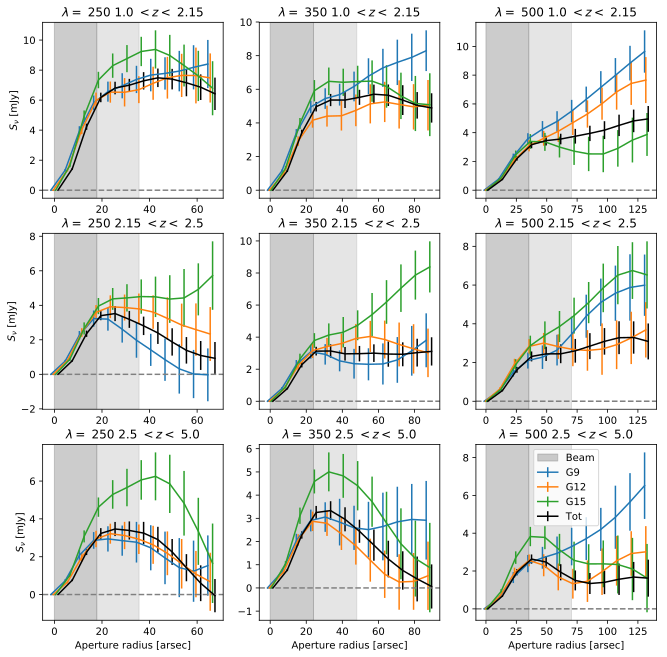

In [25]:
rmax = 12
nsim = 100

i = 1 
plt.figure(figsize=(11,11))
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
        plt.subplot(3,3,i)
        plt.title(r'$\lambda=$ '+str(lambda_) +' '+ str(zbin[0]) + r' $ < z < $ '+ str(zbin[1]))
        
        err9   = [anal.GetBootstrapErrs(lambda_, 'G9',  idz, r, remove_max=15, nsim=nsim) for r in np.arange(rmax)]
        err12  = [anal.GetBootstrapErrs(lambda_, 'G12', idz, r, remove_max=15, nsim=nsim) for r in np.arange(rmax)]
        err15  = [anal.GetBootstrapErrs(lambda_, 'G15', idz, r, remove_max=15, nsim=nsim) for r in np.arange(rmax)]
        errTot = [anal.GetTotBootstrapErrs(lambda_, idz, r, remove_max=15, nsim=nsim) for r in np.arange(rmax)]

        plt.errorbar(reso[lambda_]*np.arange(rmax)-1.5, [anal.GetPhotometryFromStacks(lambda_, 'G9',  idz, r, remove_max=1) for r in np.arange(rmax)], yerr=err9, label='G9')
        plt.errorbar(reso[lambda_]*np.arange(rmax)-0.5, [anal.GetPhotometryFromStacks(lambda_, 'G12', idz, r, remove_max=1) for r in np.arange(rmax)], yerr=err12, label='G12')
        plt.errorbar(reso[lambda_]*np.arange(rmax)+0.5, [anal.GetPhotometryFromStacks(lambda_, 'G15', idz, r, remove_max=1) for r in np.arange(rmax)], yerr=err15, label='G15')
        plt.errorbar(reso[lambda_]*np.arange(rmax)+1.5, [anal.GetTotPhotometryFromStacks(lambda_, idz, r, remove_max=15) for r in np.arange(rmax)], yerr=errTot, label='Tot', color='k')

        plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
        plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
        plt.axhline(ls='--', color='grey')

        if i == 9:
            plt.legend()

        if i > 6:
            plt.xlabel(r'Aperture radius [arsec]')
        if i == 1 or i == 4 or i == 7:
            plt.ylabel(r'$S_{\nu}$ [mJy]')

            i += 1

202
556
202
531
665
398
530
852
647
529


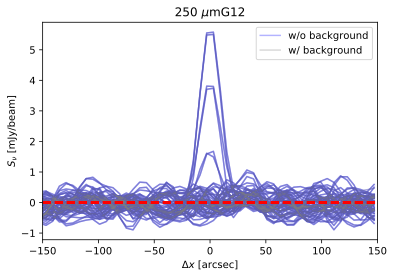

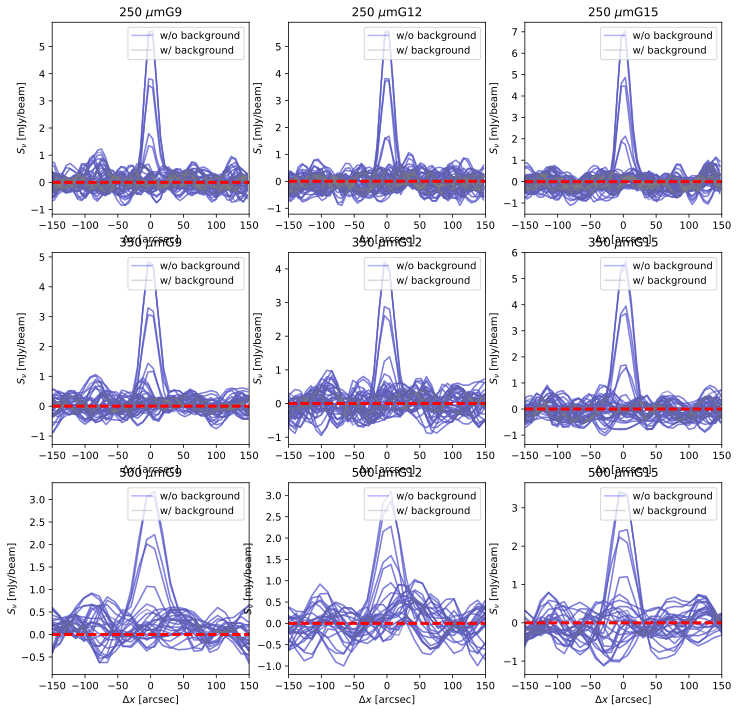

In [53]:
def plot_slice(lambda_, patch, idz, remove_max=True):
    simuls = anal.cuts[lambda_][patch][idz].copy()
    if remove_max:
        print np.argmax(np.mean(simuls,axis=(1,2)))
        simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
        simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
        simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
        simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)

    for i in xrange(boxsize[lambda_]):
        if i == 10:
            plt.plot(reso[lambda_]*(np.arange(boxsize[lambda_])-positions[lambda_][0]), (simuls.mean(axis=0)-anal.bkd[lambda_][patch][idz].mean())[i,:]/1e-3, color='blue', alpha=0.3, label='w/o background')
        else:
            plt.plot(reso[lambda_]*(np.arange(boxsize[lambda_])-positions[lambda_][0]), (simuls.mean(axis=0)-anal.bkd[lambda_][patch][idz].mean())[i,:]/1e-3, color='blue', alpha=0.5)#, label='w/ background')

    for i in xrange(boxsize[lambda_]):
        if i == 10:
            plt.plot(reso[lambda_]*(np.arange(boxsize[lambda_])-positions[lambda_][0]), (simuls.mean(axis=0))[i,:]/1e-3, color='grey', alpha=0.3, label='w/ background')
        else:
            plt.plot(reso[lambda_]*(np.arange(boxsize[lambda_])-positions[lambda_][0]), (simuls.mean(axis=0))[i,:]/1e-3, color='grey', alpha=0.3)#, label='w/ background')
    plt.axhline(ls='--',lw=3, color='r')
    plt.title(str(lambda_) + r' $\mu$m' + patch)
    plt.legend(loc='best')
    plt.xlabel(r'$\Delta x$ [arcsec]')
    plt.ylabel(r'$S_{\nu}$ [mJy/beam]')
#     plt.ylim([-0.05,0.4])
    plt.xlim([-2.5*60.,2.5*60])
    
plot_slice(250, 'G12', 0)

fig = plt.figure(figsize=(12,12))
j = 1
for lambda_ in lambdas:
    for patch in patches:
        plt.subplot(3,3,j)
        plot_slice(lambda_, patch, 0)
        j+=1

250 1.0 2.15 6.68974862478
350 1.0 2.15 5.45733583959
500 1.0 2.15 3.49917192795
250 2.15 2.5 3.94756887054
350 2.15 2.5 3.99884780697
500 2.15 2.5 2.66779805658
250 2.5 5.0 3.71175856559
350 2.5 5.0 3.89532619895
500 2.5 5.0 3.40925317291


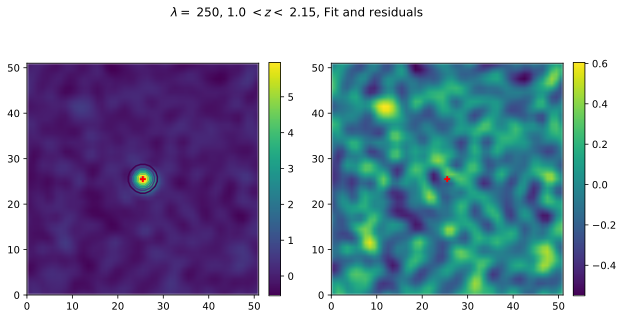

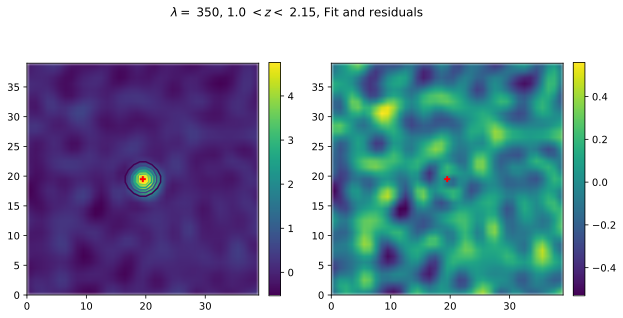

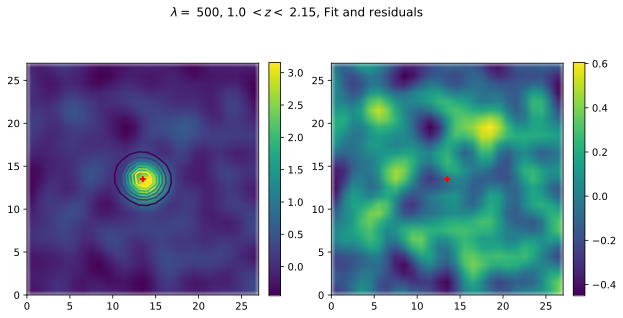

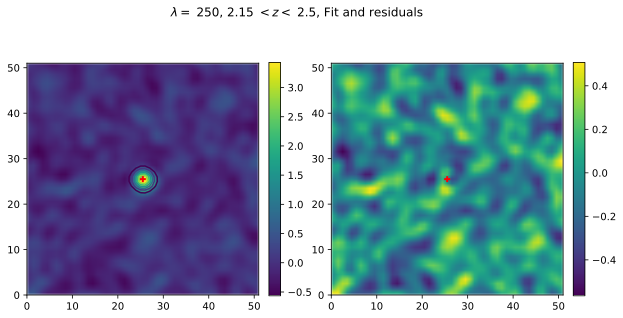

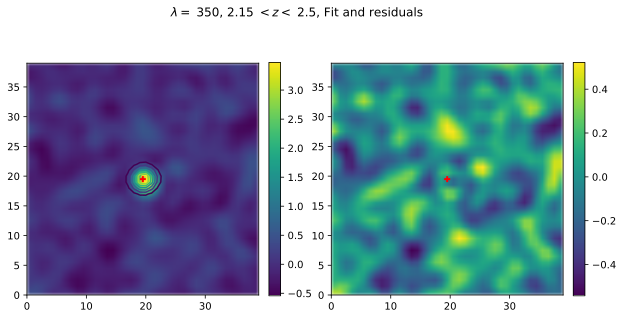

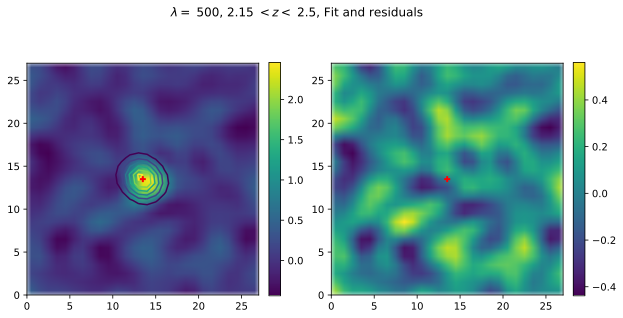

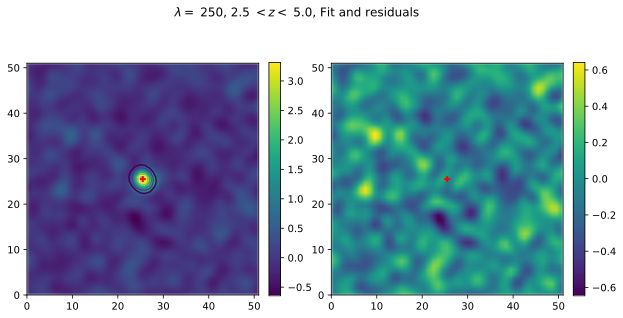

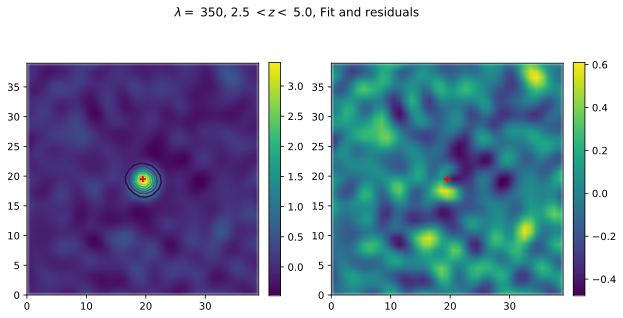

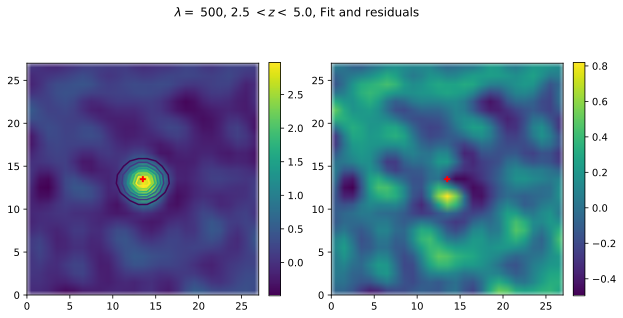

In [63]:
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            p = anal.GaussFitTot(lambda_, idz, remove_max=3, remove_mean=True, plot=True)
            print lambda_, zbin[0], zbin[1], p.amplitude.value
            plt.savefig('H-ATLAS_filtered_'+str(lambda_)+'_'+str(zbin[0])+'_'+str(zbin[1])+'.pdf')

In [56]:
for idz, zbin in enumerate(zbins):
    for lambda_ in lambdas:
            err = anal.GetTotBootstrapErrsFit2D(lambda_, idz, remove_mean=True, remove_max=2, nsim=500, nboot=2.)
            print lambda_, zbin[0], zbin[1], err

250 1.0 2.15 0.302391792286
350 1.0 2.15 0.278340511928
500 1.0 2.15 0.256530443655
250 2.15 2.5 0.24786328063
350 2.15 2.5 0.269615248577


500 2.15 2.5 0.291502353343
250 2.5 5.0 0.244800763718
350 2.5 5.0 0.256376397548
500 2.5 5.0 0.260033070718


In [59]:
for lambda_ in lambdas:
        err = anal.GetTotZBootstrapErrsFit2D(lambda_, remove_mean=True, remove_max=2, nsim=500, nboot=2.)
        print lambda_, err

250 0.158009854872
350 0.147754160384
500 0.143497696728


In [297]:
# def GetS2N(cuts, lam):
#     cut = cuts.copy()
# #     cut = cut - cut.mean()
#     apertures = CircularAperture(positions[lam], r=1*psf[lam]/reso[lam])
#     annulus_apertures = CircularAnnulus(positions[lam], r_in=1*psf[lam]/reso[lam], r_out=7*np.sqrt(1)*psf[lam]/reso[lam])
#     apers = [apertures, annulus_apertures]

#     phot_table = aperture_photometry(cut, apers)
# #     print phot_table
    
#     bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area() # mJy/pix
#     bkg_sum = bkg_mean * apertures.area() # mJy 
    
#     source_mean = phot_table['aperture_sum_0'] / apertures.area() # mJy/pix
    
# #     print source_mean, bkg_mean
    
#     return source_mean/bkg_mean

def GetS2N(cuts, lam):
    cut = cuts.copy()
    cut += 1e1
#     cut = cut - cut.mean()
    X, Y = np.meshgrid(np.arange(-cut.shape[1]/2, cut.shape[1]/2), np.arange(-cut.shape[0]/2, cut.shape[0]/2))
    R = np.sqrt(X**2+Y**2)
   
    circle = cut[R <= 1.*psf[lam]/reso[lam]]
    rest   = cut[R > 2.*psf[lam]/reso[lam]]
            
    return circle.mean()/rest.mean()

def GetMeIndex(cuts, lam):
    ind = []
    for i, cut in enumerate(cuts):
        if GetS2N(cut, lam) > 5:
            ind.append(i)
        else:
            pass
    return np.asarray(ind)

In [341]:
def ComputeS2N(cuts, lam):
    s2n = []
    for i, cut in enumerate(cuts):
        s2n.append(GetS2N(cut, lam))
    return s2n

def AmIResolved(cuts, lam, sigma=3.):
    s2n = ComputeS2N(cuts, lam)
    stamps = np.where(s2n > sigma*np.std(s2n) + np.mean(s2n))[0]
    return stamps

In [368]:
AmIResolved(anal.cuts[250]['G12'][0], 250)

array([ 26, 126, 235, 244, 292, 376, 497, 561, 575])

1.002997

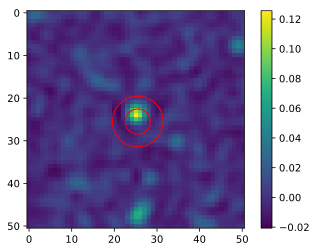

In [374]:
n = 292

ax = plt.subplot(111)
plt.imshow(anal.cuts[250]['G12'][0][n]); plt.colorbar()
circin = plt.Circle(positions[250], radius=1*psf[250]/reso[250], color='r', fill=False)
circout = plt.Circle(positions[250], radius=2*np.sqrt(1)*psf[250]/reso[250], color='r', fill=False)
circouter = plt.Circle(positions[250], radius=100*psf[250]/reso[250], color='r', fill=False)
ax.add_patch(circin)
ax.add_patch(circout)
ax.add_patch(circouter)

# plt.subplot(122)
# plt.imshow(anal.cuts[350]['G12'][0][n]); plt.colorbar()
GetS2N(anal.cuts[250]['G12'][0][n], 250)
# GetS2N(np.ones_like(anal.cuts[250]['G12'][0][n]), 250)


In [362]:
for lam in lambdas:
    print 'lambda: ', lam, '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    for patch in patches:
        print '--> patch: ', patch
        for iz, zbin in enumerate(zbins):
            res = AmIResolved(anal.cuts[lam][patch][iz], lam, sigma=4)
            print '\t--> zbin',zbin ,': N_resolved/N_total = %.3f' %(1.*len(res)/len(anal.cuts[lam][patch][iz]))

lambda:  250 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--> patch:  G9
	--> zbin (1.0, 2.15) : N_resolved/N_total = 0.007
	--> zbin (2.15, 2.5) : N_resolved/N_total = 0.008
	--> zbin (2.5, 5.0) : N_resolved/N_total = 0.005
--> patch:  G12
	--> zbin (1.0, 2.15) : N_resolved/N_total = 0.004
	--> zbin (2.15, 2.5) : N_resolved/N_total = 0.002
	--> zbin (2.5, 5.0) : N_resolved/N_total = 0.003
--> patch:  G15
	--> zbin (1.0, 2.15) : N_resolved/N_total = 0.003
	--> zbin (2.15, 2.5) : N_resolved/N_total = 0.003
	--> zbin (2.5, 5.0) : N_resolved/N_total = 0.006
lambda:  350 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--> patch:  G9
	--> zbin (1.0, 2.15) : N_resolved/N_total = 0.006
	--> zbin (2.15, 2.5) : N_resolved/N_total = 0.003
	--> zbin (2.5, 5.0) : N_resolved/N_total = 0.004
--> patch:  G12
	--> zbin (1.0, 2.15) : N_resolved/N_total = 0.001
	--> zbin (2.15, 2.5) : N_resolved/N_total = 0.002
	--> zbin (2.5, 5.0) : N_resolved/N_total = 0.003
--> patch:  G15
	--> zbin (1.0, 2.15) : N_resolv